<a href="https://colab.research.google.com/github/david900125/113NCHU_Big-Data-Analytics-for-Finance/blob/main/week09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf

In [32]:
# 爬取證券交易所的股價資料
def fetch_stock_data_exchange(stock_code):
  stock = yf.Ticker(f"{stock_code}.TW")
  data = stock.history(period='max',interval='1d')
  return data

In [33]:
stock_code = '6139'  # 替換為實際的股號
data = fetch_stock_data_exchange(stock_code)
# data['date'] = pd.to_datetime(data['Date'])
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-08-25 00:00:00+08:00,19.896514,19.896514,18.597141,18.921980,1914209,0.0,0.0
2003-08-26 00:00:00+08:00,19.165613,19.490454,17.947458,18.191090,3817729,0.0,0.0
2003-08-27 00:00:00+08:00,18.678355,18.678355,17.541410,17.541410,2476990,0.0,0.0
2003-08-28 00:00:00+08:00,17.378990,17.622622,16.404469,16.648098,3575433,0.0,0.0
2003-08-29 00:00:00+08:00,16.648095,17.785038,16.242046,17.785038,3437350,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-06 00:00:00+08:00,227.000000,230.000000,226.500000,227.000000,1174607,0.0,0.0
2024-11-07 00:00:00+08:00,227.500000,237.000000,227.500000,234.500000,3544202,0.0,0.0
2024-11-08 00:00:00+08:00,235.000000,238.500000,230.000000,232.500000,1904063,0.0,0.0


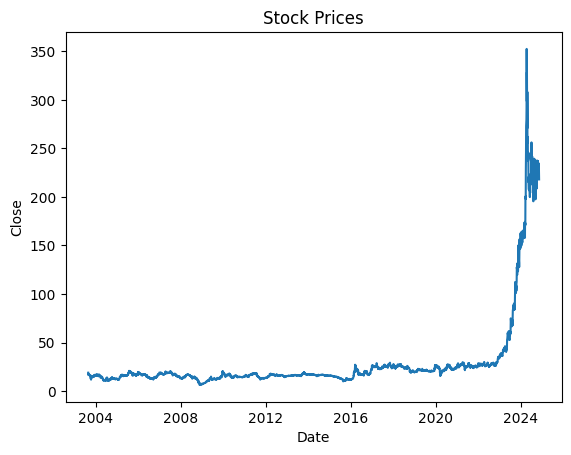

In [34]:
plt.plot(data.index,data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Stock Prices")
plt.show()

In [35]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

4982


In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]

# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

model.compile(optimizer='adam',
			loss='mean_squared_error')

history = model.fit(x_train,
            y_train,
            epochs=10)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - loss: 3.5051e-04
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - loss: 1.3931e-05
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - loss: 1.6776e-05
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 1.3688e-05
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 1.5577e-05
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 1.1827e-05
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - loss: 1.5113e-05
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 9.1429e-06
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 9.9077e-06
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - loss: 8.7467e-06


In [23]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
print(predictions.shape)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
(262, 1)
MSE 405.58720576114047
RMSE 20.139195757555477


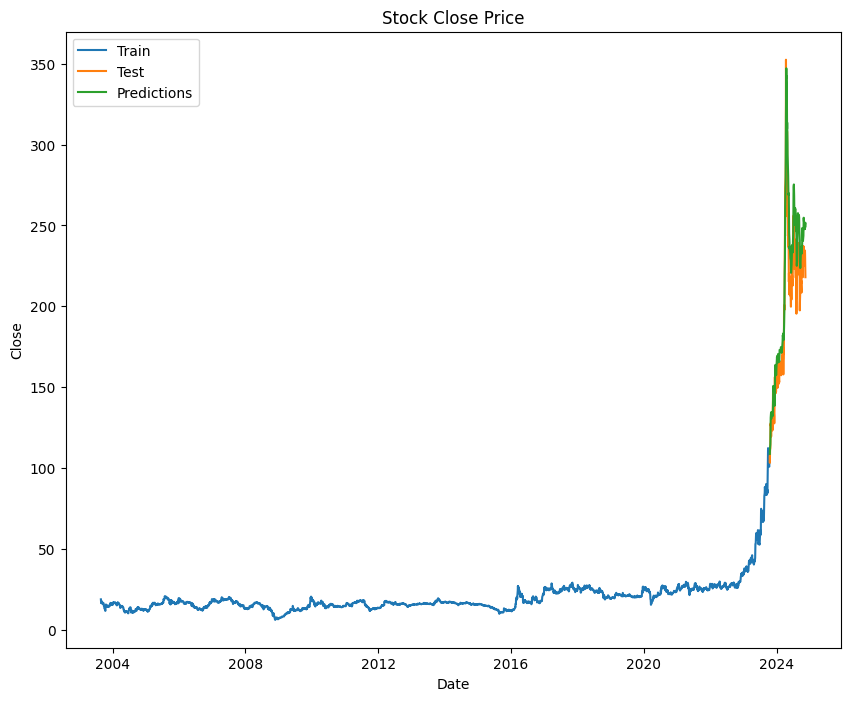

In [24]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train.index, train['Close'])
plt.plot(test.index, test[['Close', 'Predictions']])
plt.title('Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

# Transformer



In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [39]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
  x = LayerNormalization(epsilon=1e-6)(inputs)
  x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
  x = Dropout(dropout)(x)
  res = x + inputs

  x = LayerNormalization(epsilon=1e-6)(res)
  x = Dense(ff_dim, activation="relu")(x)
  x = Dropout(dropout)(x)
  x = Dense(inputs.shape[-1])(x)
  return x + res

# Model Definition
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=64, verbose=1)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 60, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 60, 1)          │              2 │ input_layer_1[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 1)          │          7,169 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60, 1)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 60, 1)          │              0 │ dropout_1[0][0],       │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 60, 1)          │              2 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 60, 4)          │              8 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 60, 4)          │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 60, 1)          │              5 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 60, 1)          │              0 │ dense_3[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 60)             │              0 │ add_1[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 60)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 20)             │          1,220 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             21 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,427 (32.92 KB)

 Trainable params: 8,427 (32.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - loss: 5.9025e-04
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - loss: 1.7184e-04
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 1.3054e-04
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - loss: 9.6826e-05
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - loss: 7.4507e-05
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - loss: 5.9757e-05
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 6.1811e-05
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - loss: 5.2728e-05
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - loss: 4.5121e-05
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - loss: 4.1372e-05
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 3.5758e-05
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - loss: 3.4302e-05
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 2.8800e-05
Epoch 14/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - loss

In [40]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
print(predictions.shape)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
(262, 1)
MSE 7379.765301110721
RMSE 85.9055603620087


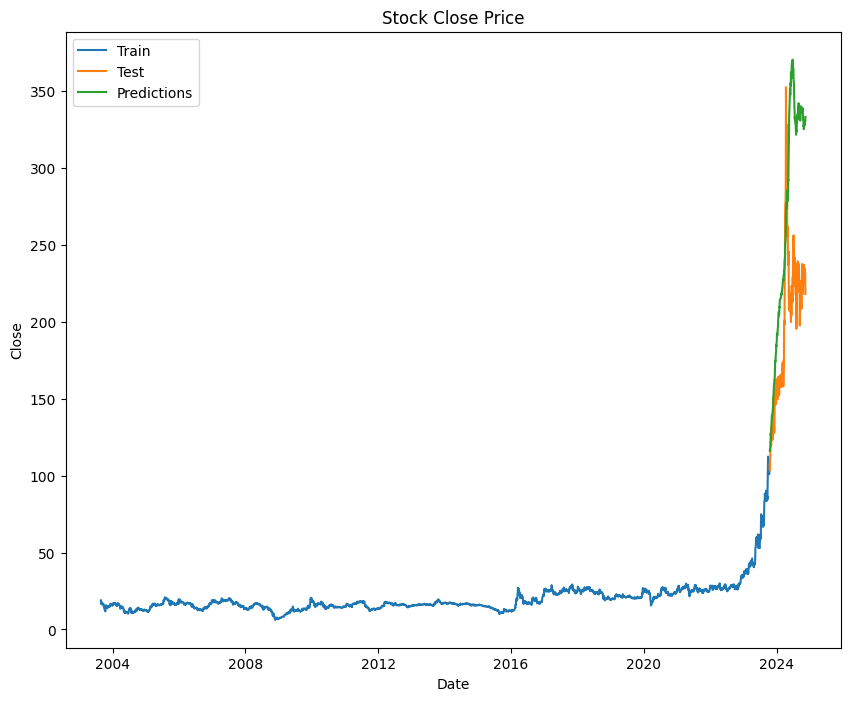

In [41]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train.index, train['Close'])
plt.plot(test.index, test[['Close', 'Predictions']])
plt.title('Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])